In [9]:
] activate ../../Acceleration

 Activating environment at `~/Desktop/Code/Acceleration/Acceleration/Project.toml`


In [17]:
using Acceleration
using LinearAlgebra

n = 1000; # number of samples
d = 50;    # number of features
selected_labels = [0,1];  ## Only two labels allowed

data, labels = load_dataset("MNIST",[0,2],n,d);
f,∇f,∇ϕ_cjg,σ,L,μ  = linear_regression(data,labels);

┌ Info: Loading dataset MNIST with 60000 samples and 784 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/datasets.jl:26


In [18]:
n = size(data,2)
x_ini = zeros(n)

using JuMP
using Ipopt

@time model = Model(with_optimizer(Ipopt.Optimizer))
@time set_silent(model)
@time @variable(model, x[1:n])
@time @objective(model, Min, f(x))
@time optimize!(model)
@time x_opt = value.(x);

  0.000181 seconds (652 allocations: 36.172 KiB)
  0.000002 seconds
  0.039954 seconds (63.86 k allocations: 3.307 MiB)
  0.087742 seconds (22.77 k allocations: 52.967 MiB)
  0.003391 seconds (911 allocations: 173.641 KiB)
  0.000123 seconds (603 allocations: 12.234 KiB)


In [19]:
n = length(x_ini)
x = x_ini;
y = zeros(n);
z = zeros(n);
v = zeros(n);
A0 = σ/(2*L);
A = A0;
AX = zeros(n);
A2 = 0;

k = 1000;
aks = zeros(k);
R = zeros(k);
xks = zeros(n,k);
axks = zeros(n,k);
yks = zeros(n,k);
zks = zeros(n,k);
up = zeros(k);
#μ = 0;
s = zeros(n);
noise = 0;

function varphi_k_cjg(k,z,μ,aks,xks)
    A = sum(aks[1:k])
    AX = sum(axks[:,1:k], dims=2)
    v = (z + μ*AX)*inv(1 + μ*(A-A0));
    w = 0
    for i=1:k
        w = w + aks[i]*norm(xks[:,i]-v,2)^2;
    end
    return z'*x - (1/2)*norm(v,2)^2 - (μ/2)*w
end

for i=1:k   
   
    a = L-μ; b = -(μ*A + σ); c = -μ*A^2 - σ*A;
    α = (-b + sqrt(b^2 - 4*a*c)) / (2*a);
    A = A + α;
    x = (A-α)/A*y + α/A*v; 
    AX = AX + α*x;

    η = zeros(n)
    approx_gradient = ∇f(x)+η;
    
    s = s + α*η;
    z = z - α*approx_gradient;
    
    v_past = v;
    v = (z + μ*AX)*inv(1 + μ*(A-A0));
    y = (A-α)*inv(A)*y + α*inv(A)*v; 

    yks[:,i] = y;
    
    println(norm(v-v_past,2)^2)
    

end

x_out = yks;
x_gd = gradient_descent(f,∇f,∇ϕ_cjg,x_ini,σ,L,k);
x_amd = accelerated_mirror_descent(f,∇f,∇ϕ_cjg,x_ini,σ,L,k);
x_amd2 = SCVX_AMD(f,∇f,∇ϕ_cjg,x_ini,σ,L,μ,k);

0.004635848369834549
0.005838459801263066
0.005715916132110944
0.004446032434215769
0.002806799856277321
0.0014812981153520253
0.0007736868512117806
0.0006159355212478218
0.0007424442271096814
0.00088846632382043
0.0009096555645487103
0.000796643022235021
0.0006194262713625439
0.00045694783792720253
0.00035243449144260476
0.000305883653675374
0.00029184309306344927
0.00028276485620924805
0.00026358459659275206
0.00023368718415628262
0.00020056126680818162
0.00017197167968953313
0.0001513870773920667
0.00013769548688844885
0.00012753929034188478
0.00011791187898699799
0.00010750853299245475
9.662130665245124e-5
8.623541656594743e-5
7.713939742289134e-5
6.951760650689688e-5
6.304259796710466e-5
5.721184235520255e-5
5.164958059642169e-5
4.622880943066219e-5
4.102313661398652e-5
3.618282786172301e-5
3.182859438136362e-5
2.8007177787019523e-5
2.470161824603573e-5
2.1864145638147856e-5
1.9442863085821245e-5
1.7390778166147596e-5
1.5661626011079916e-5
1.4203181608237242e-5
1.295598118938462e-

1.584099019136524e-22
1.3802214784466564e-22
1.204221688654368e-22
1.0522634604959054e-22
9.210039980238242e-23
8.075820940649093e-23
7.094968850539949e-23
6.246044185178278e-23
5.510597415616382e-23
4.872686222994838e-23
4.318709515004667e-23
3.8369584383686265e-23
3.417378257677266e-23
3.0514217324559814e-23
2.731623209032496e-23
2.4517088066080529e-23
2.206229812788528e-23
1.9905395649637544e-23
1.8005799782458282e-23
1.6329723007445414e-23
1.4846911865333286e-23
1.353213902644193e-23
1.2363347874036321e-23
1.1321589834853354e-23
1.0390242611673653e-23
9.555478623235928e-24
8.804992317157053e-24
8.127961928751157e-24
7.515593537171284e-24
6.959783474492956e-24
6.453846873728591e-24
5.9917118670271914e-24
5.5683999715156266e-24
5.1794399985179565e-24
4.821195467794837e-24
4.489993034971388e-24
4.183343936274399e-24
3.8985915194247264e-24
3.633688754234265e-24
3.386665325886212e-24
3.1560213552709885e-24
2.940306745206157e-24
2.738280544200907e-24
2.5490841978100106e-24
2.371472388958

6.616622601908492e-32
1.2852892847710118e-31
1.3705436582564893e-31
7.355792257615158e-32
1.2261948327664738e-31
8.065546342686849e-32
7.843199235240113e-32
9.24194347317057e-32
7.373622155928431e-32
6.641072884405594e-32
2.2414984558315843e-31
1.1739246426859736e-30
6.2858817497792105e-31
1.1234716728322964e-31
1.1130219982512265e-31
1.0334664213785354e-31
1.8460038516951658e-31
1.3575850085330247e-31
5.609270963027824e-32
9.548117433763145e-32
2.922542266878791e-32
2.1103377365623137e-31
1.8325561963217586e-31
4.522060939929694e-32
8.311741879523071e-32
1.490874783170504e-31
9.982787032832808e-32
6.477237183765388e-32
4.891504708460929e-32
1.349753394970106e-31
8.217589483999608e-32
1.4063426334141716e-32
6.740040104790024e-32
2.9105164894721386e-31
2.6811295814571968e-31
2.556779206258851e-31
2.861941301314239e-31
6.071080375669272e-31
4.646420719082846e-31
9.049839484381788e-32
7.819125110935272e-32
6.62025252846383e-32
5.947657230414854e-31
5.6321752353547265e-31
3.364302447872613

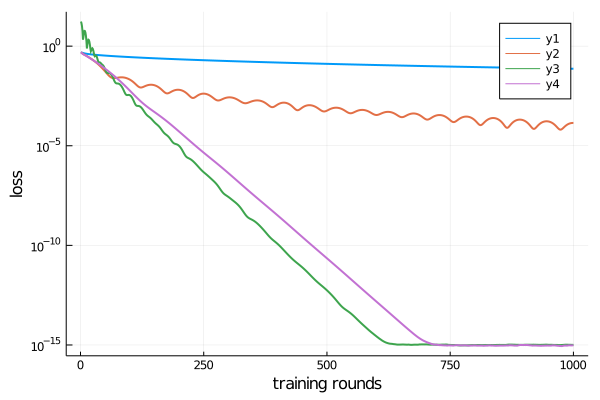

In [20]:
using Plots
using LinearAlgebra

p_out = sqrt.(sum((x_out .- x_opt).^2, dims=1)');
p_gd = sqrt.(sum((x_gd .- x_opt).^2, dims=1)');
p_amd = sqrt.(sum((x_amd .- x_opt).^2, dims=1)');
p_amd2 = sqrt.(sum((x_amd2 .- x_opt).^2, dims=1)');

plot(max.(hcat(p_gd,p_amd,p_amd2,p_out),1e-20),yaxis=:log,linewidth=2,xlabel="training rounds",ylabel="loss")
#plot(max.(hcat(p_out),1e-20),yaxis=:log)